## Get Scenario Data

In [1]:
from tutorials.utils.tutorial_utils import setup_notebook
setup_notebook()
import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '../../nuplan/dataset')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '../../nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '../../nuplan/dataset/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

In [2]:
from nuplan.planning.script.builders.scenario_building_builder import build_scenario_builder
from nuplan.planning.script.builders.scenario_filter_builder import build_scenario_filter
from nuplan.planning.script.builders.worker_pool_builder import build_worker

### set up config file - edit in the config access to change ###
import hydra
CONFIG_PATH = "../nuplan-devkit/nuplan/planning/script/config/common/myconfigs"
CONFIG_NAME = "scenario_access"
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[])
###

### create all scenario objects as specified in config file ###
scenario_builder = build_scenario_builder(cfg)
scenario_filter = build_scenario_filter(cfg.scenario_filter)
worker = build_worker(cfg)
scenarios = scenario_builder.get_scenarios(scenario_filter, worker) # List[AbstractScenario]

## LQR Class

In [16]:
from math import sqrt
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.common.actor_state.state_representation import TimeDuration
import numpy as np


# imports for BFS
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import SemanticMapLayer
from matplotlib import pyplot as plt

from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.maps.abstract_map_objects import LaneGraphEdgeMapObject
from typing import List, Tuple
from nuplan.planning.simulation.planner.utils.breadth_first_search import BreadthFirstSearch
import math
import torch

from shapely import LineString
import shapely

class LQRData():
    
    def __init__(self, scenario, closest=5):
        self.s = scenario
        
        self.data = {} # to be used for LQR
        
        self.duration = self.s.duration_s # TimeDuration Object in seconds
        self.num_frames = self.s.get_number_of_iterations() - 1
        self.scenario_type = self.s.scenario_type
        
        self.n = closest
        self.closest_neighbors_id = []
        
        # bfs vars
        self.route_roadblocks = []
        self.candidate_lane_edge_ids = []
        self.init = self.s.initial_ego_state.center
        self.fin = self.s.get_expert_goal_state()
        
    def populate_data(self):
        self.data['current_pos_gb'] = self.get_current_ego_pos_gb()
        self.data['current_pos'] = self.get_current_ego_pos()
        self.data['future_pos'] = self.get_future_ego_pos()
        #self.data['current_neighbor_pos'] = self.get_current_neighbor_pos()
        self.data['future_neighbor_pos'] = self.get_future_neighbor_pos_padded()
        self.data['current_neighbor_pos'] = self.data['future_neighbor_pos'][:, 0, :]
        self.data['current_lane'] = self.get_current_lane()
        
        #self.relative_to_current_pos_gb()
        self.add_batch_size_dimension()
    
    # def relative_to_current_pos_gb(self):
#         self.data['future_pos'] = self.data['future_pos'] - self.data['current_pos_gb']
#         self.data['current_neighbor_pos'] = self.data['current_neighbor_pos'] - self.data['current_pos_gb']
#         self.data['current_lane'] = self.data['current_lane'] - self.data['current_pos_gb']
        
            
    def add_batch_size_dimension(self):
        
        for key in self.data:
            self.data[key] = torch.unsqueeze(self.data[key], 0)
    
    def get_current_ego_pos_gb(self):
        return torch.Tensor(self.get_xy_from_egostate(self.s.initial_ego_state))
    
    def get_current_ego_pos(self):
        return torch.Tensor((0, 0))
    
    def get_future_ego_pos(self):
        future_ego_pos = []
        for ego in self.s.get_ego_future_trajectory(0, self.duration.time_s):
            future_ego_pos.append(self.get_xy_from_egostate(ego))
        return torch.Tensor(future_ego_pos)
    
    def get_future_neighbor_pos_padded(self):
        veh = {}
        # for each frame
        for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
            # for each tracked vehicle
            for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
                veh[obj.track_token] = [(0.0, 0.0)] * s0.num_frames

        # populate known vehicle positions
        frame_id = 0
        for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
            # for each tracked vehicle
            for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
                veh[obj.track_token][frame_id] = self.get_xy_from_agent(obj)
            frame_id += 1
        
        return torch.Tensor(list(veh.values()))
        

    def get_current_neighbor_pos(self):
        
        neighbors = self.s.initial_tracked_objects.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE)
        
        neighbors = sorted(neighbors, key=lambda ag:self.dist(self.data['current_pos_gb'], 
                                                               self.get_xy_from_agent(ag)))
        assert(self.n <= len(neighbors))
        if self.n < 0:
            near_neighbors = neighbors
        else:
            near_neighbors = neighbors[:self.n]
        self.closest_neighbors_id = [x.track_token for x in near_neighbors]
        return torch.Tensor([self.get_xy_from_agent(ag) for ag in near_neighbors])
    
    def get_xy_from_agent(self, agent):
        return (agent.center.x, agent.center.y)
    
    def get_xy_from_egostate(self, ego):
        return ego.waypoint._oriented_box.center.x, ego.waypoint._oriented_box.center.y
    
    def dist(self, a, b):
        return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    
    def get_current_lane(self):
        # get current lane info
        bfs_output = self.get_bfs_path()
        
        full_bfs = []
        for lane in bfs_output:
            full_bfs += lane.baseline_path.discrete_path
        
        ref_path = self.trim_ref_path(full_bfs)
        
        return torch.Tensor(self.interpolate_to_dim(ref_path))
    
    def interpolate_to_dim(self, ref_path):
        line = LineString(ref_path)
        num_pts = s0.data['future_pos'].shape[0]
        distances = np.linspace(0, line.length, num_pts)
        points = [line.interpolate(distance) for distance in distances]
        return [(pt.x, pt.y) for pt in points]
        
        
    def trim_ref_path(self, full_bfs):
        
        init_dist = float('inf')
        fin_dist = float('inf')

        init_id = 0
        fin_id = 0
        
        for idx in range(len(full_bfs)):
            if init_dist > full_bfs[idx].distance_to(self.init):
                init_dist = full_bfs[idx].distance_to(self.init)
                init_id = idx
            if fin_dist > full_bfs[idx].distance_to(self.fin):
                fin_dist = full_bfs[idx].distance_to(self.fin)
                fin_id = idx
        
        ref_path = full_bfs[init_id:fin_id+1]
        return [(pt.x, pt.y) for pt in ref_path] #, [pt.y for pt in ref_path]

    
    def get_bfs_path(self):
        # get route plan from map
        route_roadblocks_ids = self.s.get_route_roadblock_ids()

        self.route_roadblocks = []
        for id_ in route_roadblocks_ids:
            block = self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK)
            block = block or self.s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK_CONNECTOR)
            self.route_roadblocks.append(block)

        # candidate lane IDs
        self.candidate_lane_edge_ids = [edge.id for block in self.route_roadblocks 
                                   if block for edge in block.interior_edges]
        
        current_lane_path, found = self.bfs(self.s.initial_ego_state)
        assert(found == True)
        return current_lane_path
        
    def get_starting_edge(self, ego_state: EgoState) -> LaneGraphEdgeMapObject:
        starting_edge = None
        closest_dist = math.inf
        found_on_roadblock = False
        for edge in self.route_roadblocks[0].interior_edges + self.route_roadblocks[1].interior_edges:
            if edge.contains_point(ego_state.center):
                starting_edge = edge
                found_on_roadblock = True
                break
            # case ego does not start on a road block
            distance = edge.polygon.distance(ego_state.car_footprint.geometry)
            if distance < closest_dist:
                starting_edge = edge
                closest_dist = distance

        if not found_on_roadblock:
            print('Picking closest approx for starting roadblock')
        return starting_edge
    
    def bfs(self, ego_state: EgoState) -> Tuple[List[LaneGraphEdgeMapObject], bool]:
        starting_edge = self.get_starting_edge(ego_state)
        graph_search = BreadthFirstSearch(starting_edge, self.candidate_lane_edge_ids)
        offset = 1 if starting_edge.get_roadblock_id() == self.route_roadblocks[1].id else 0
        route_plan, path_found = graph_search.search(self.route_roadblocks[-1], len(self.route_roadblocks[offset:]))
        if not path_found:
            logger.warning('Path not found')
        return route_plan, path_found
        

In [72]:
s0 = LQRData(scenarios[6], -1)
s0.populate_data()

Picking closest approx for starting roadblock


## Get future neighbor trajectories

In [73]:
# def get_xy_from_agent(agent):
#     return (agent.center.x, agent.center.y)
    
# veh = {}
# # for each frame
# for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
#     # for each tracked vehicle
#     for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
#         veh[obj.track_token] = [(0.0, 0.0)] * s0.num_frames

# # populate known vehicle positions
# frame_id = 0
# for det_track in s0.s.get_future_tracked_objects(0, s0.duration.time_s):
#     # for each tracked vehicle
#     for obj in det_track.tracked_objects.get_tracked_objects_of_type(TrackedObjectType.VEHICLE):
#         veh[obj.track_token][frame_id] = get_xy_from_agent(obj)
#     frame_id += 1

# torch.Tensor(list(veh.values())).shape

## Run LQR

In [74]:
from lqr import LQRPlanner

In [75]:
model_input = s0.data

In [76]:
for key in s0.data:
    print(key + ': ' + str(s0.data[key].shape))

current_pos_gb: torch.Size([1, 2])
current_pos: torch.Size([1, 2])
future_pos: torch.Size([1, 149, 2])
future_neighbor_pos: torch.Size([1, 62, 149, 2])
current_neighbor_pos: torch.Size([1, 62, 2])
current_lane: torch.Size([1, 149, 2])


In [77]:
planner = LQRPlanner()
output = planner.forward(model_input)

Initial mean(cost): 0.0000e+00
| 0 | -5.8273e+14 | 3.08e+01 | 1.00e+00 | 21 |
| 1 | -5.8273e+14 | 0.00e+00 | 1.00e+00 | 20 |


In [78]:
output['traj'].shape

torch.Size([1, 20, 2])

In [79]:
s0.data['current_pos_gb']
true = s0.data['future_pos'] - s0.data['current_pos_gb']
ref = s0.data['current_lane'] - s0.data['current_pos_gb']
pred = output['traj'].detach().numpy()

In [80]:
pred.shape

(1, 20, 2)

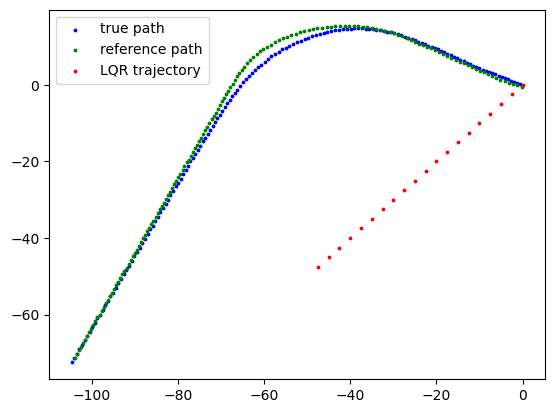

In [81]:
plt.scatter(true[0, :, 0], true[0, :, 1], color='b', label='true path', s=3)
plt.scatter(ref[0, :, 0], ref[0, :, 1], color='g', label='reference path', s=3)
plt.scatter(pred[0, :, 0], pred[0, :, 1], color='r', label='LQR trajectory', s=3)
plt.legend()